In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
from getSIDMdata_generator import get_tf_DataSet as getGenerators
from copy import deepcopy as cp
import scienceplots
import mertens_models as mertens

plt.style.use(["science", "grid"])

Objectives
----------
1. To see where the inception fails


In [3]:
checkpoint_filepath = "models/inception/0"
model = tf.keras.models.load_model(checkpoint_filepath)

In [4]:
simulationNames = ['CDM','SIDM0.1','SIDM1']

In [5]:
train, test, test_params = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl', random_state=0, return_test_params=True)

In [6]:
probs = model.predict( test[0] )
pred = np.argmax( probs, axis=-1)

2023-06-25 16:52:18.523607: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


23/23 [==============================] - 2s 63ms/step


In [7]:
compare = pred - test[1]

In [8]:
data_over = test[0][ compare > 0, :, :, 0]
data_unde = test[0][ compare < 0, :, :, 0]
data_good = test[0][ compare == 0, :, :, 0]

In [12]:
square

7.0

IndexError: index 43 is out of bounds for axis 0 with size 43

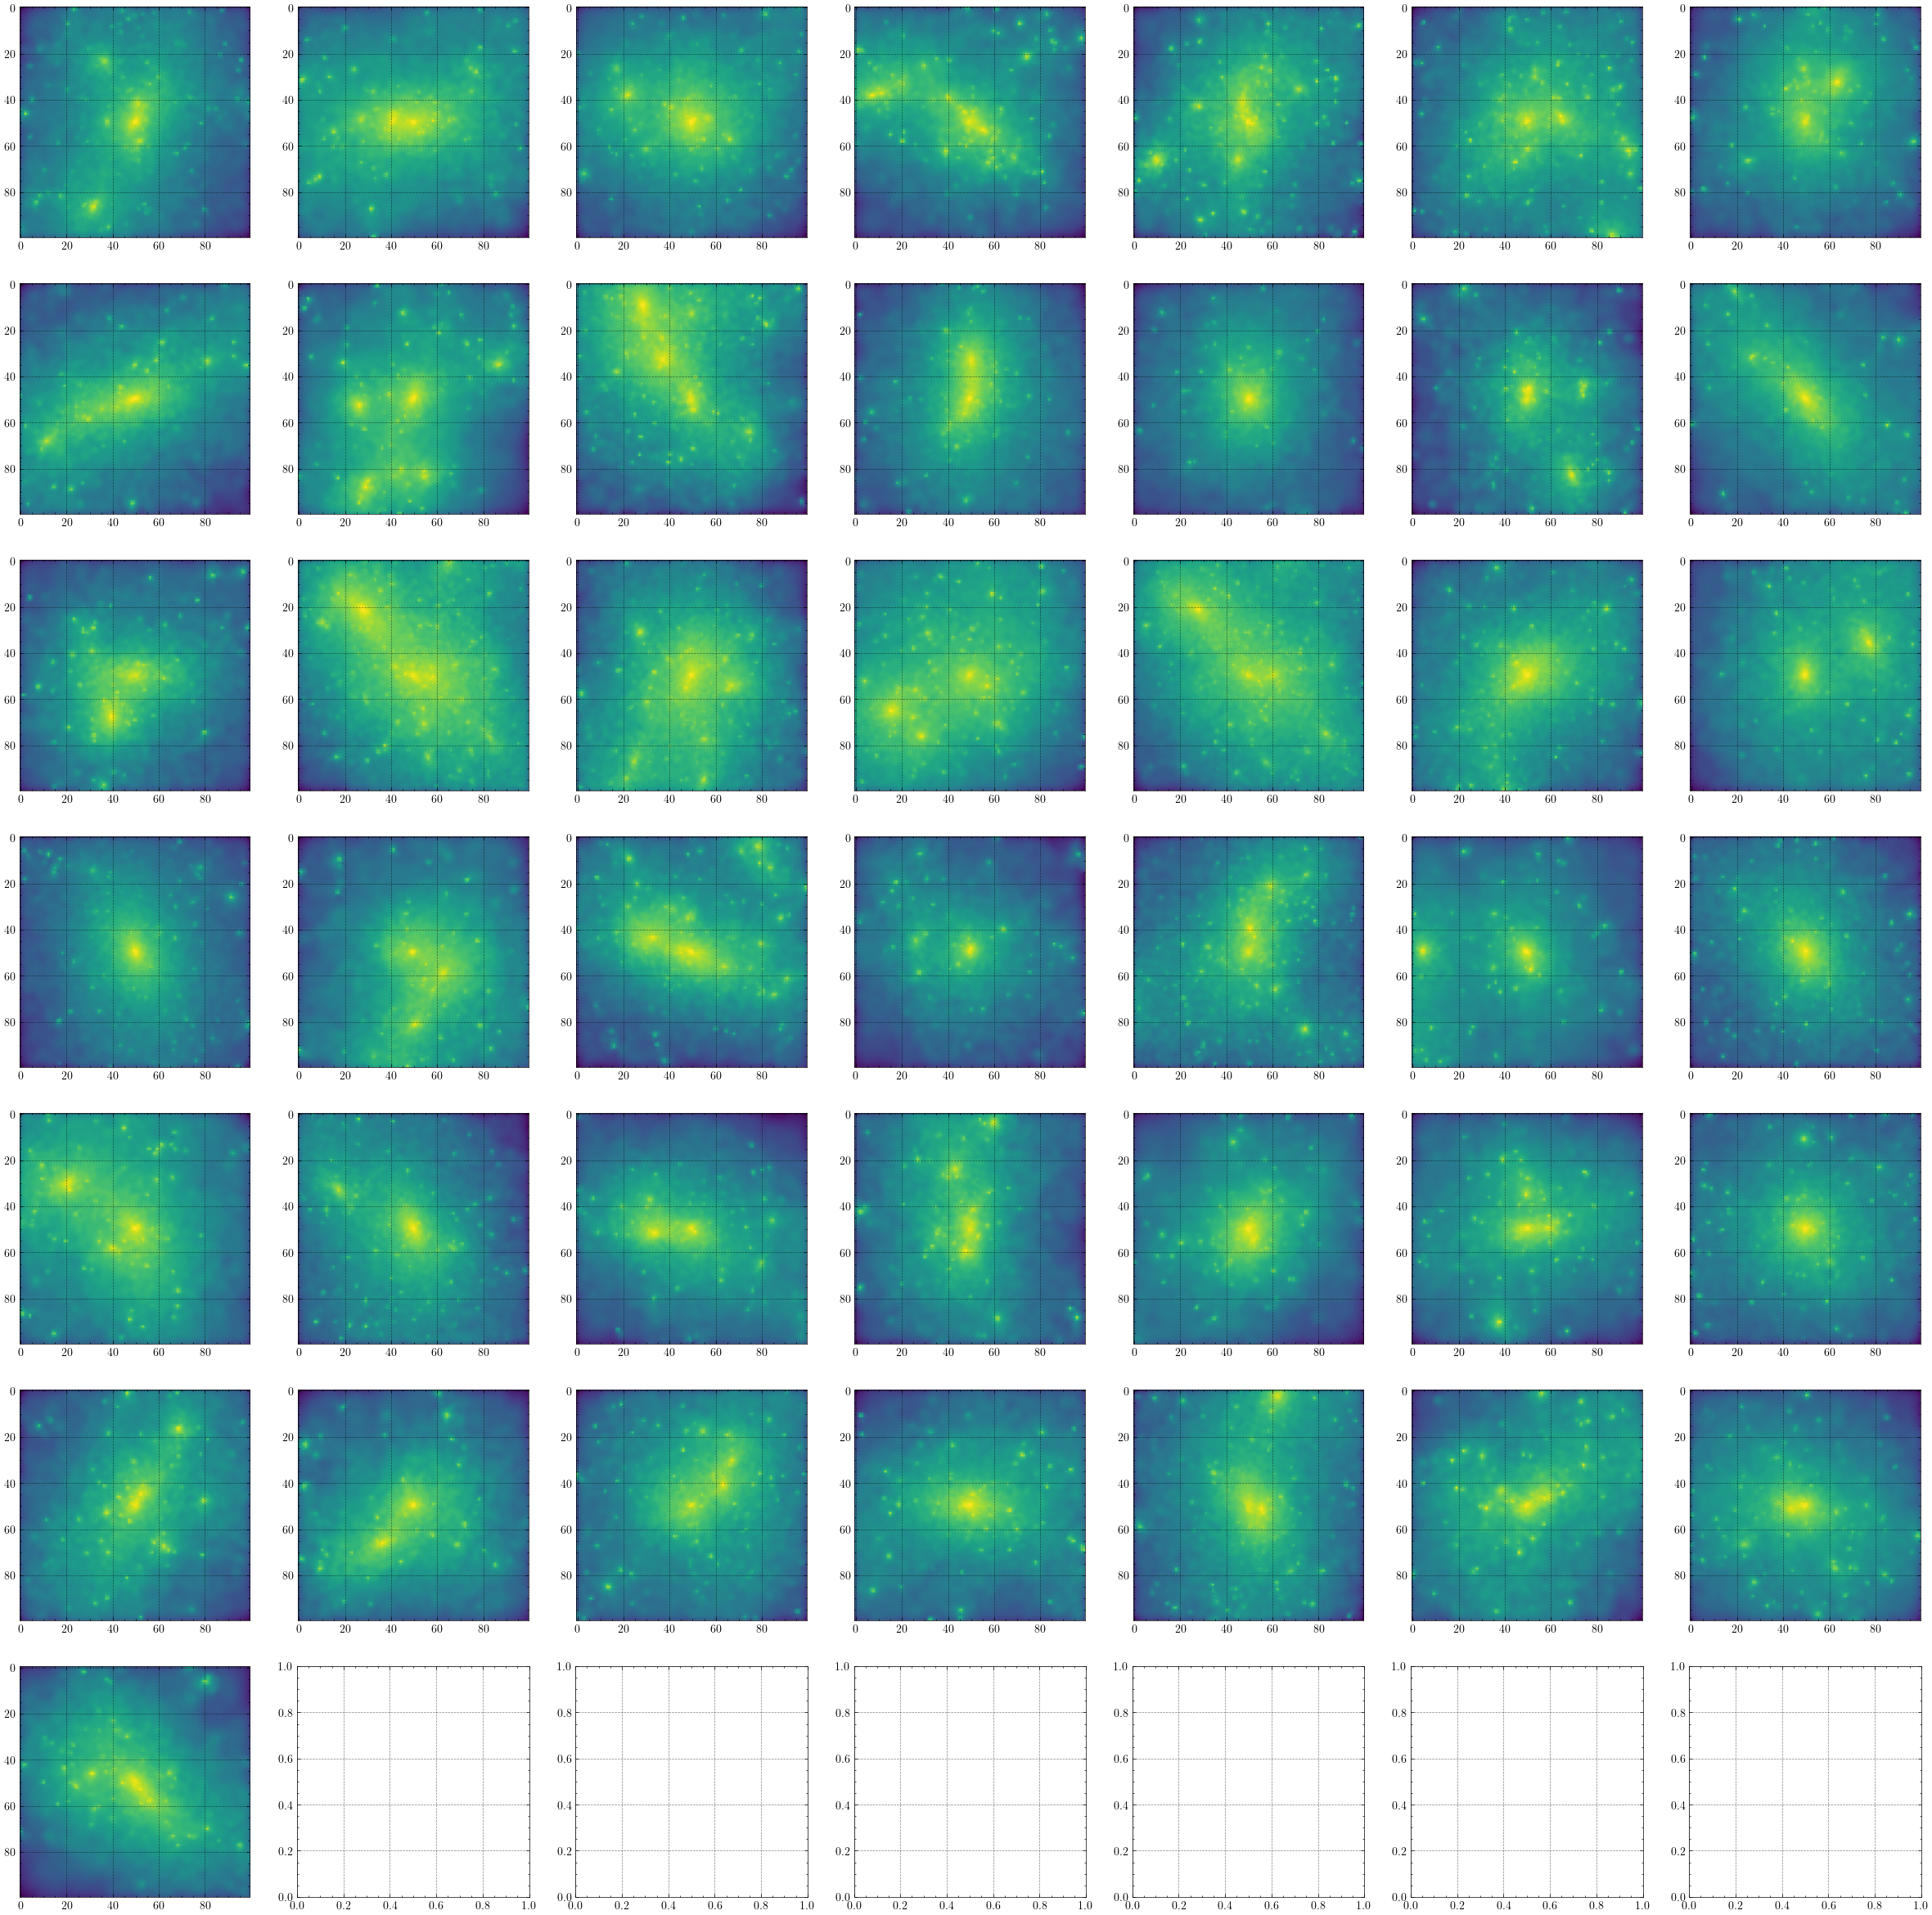

In [14]:
square = int(np.min([10, np.ceil(np.sqrt(data_over.shape[0]))]))
fig, ax = plt.subplots(square,square, figsize=(30,30))
for i in range(square):
    for j in range(square):
        k = i*square+j
        ax[i,j].imshow( np.log10(data_over[k]))

In [ ]:
fig, ax = plt.subplots(10,10, figsize=(30,30))
for i in range(10):
    for j in range(10):
        k = i*10+j
        ax[i,j].imshow( np.log10(data_good[k]))

In [36]:
test_params.keys()

dict_keys(['lensing_norm', 'label', 'redshift', 'clusterID', 'sim', 'mass', 'xrayConc'])

In [26]:
np.arange(0,0.5,6)

array([0.])

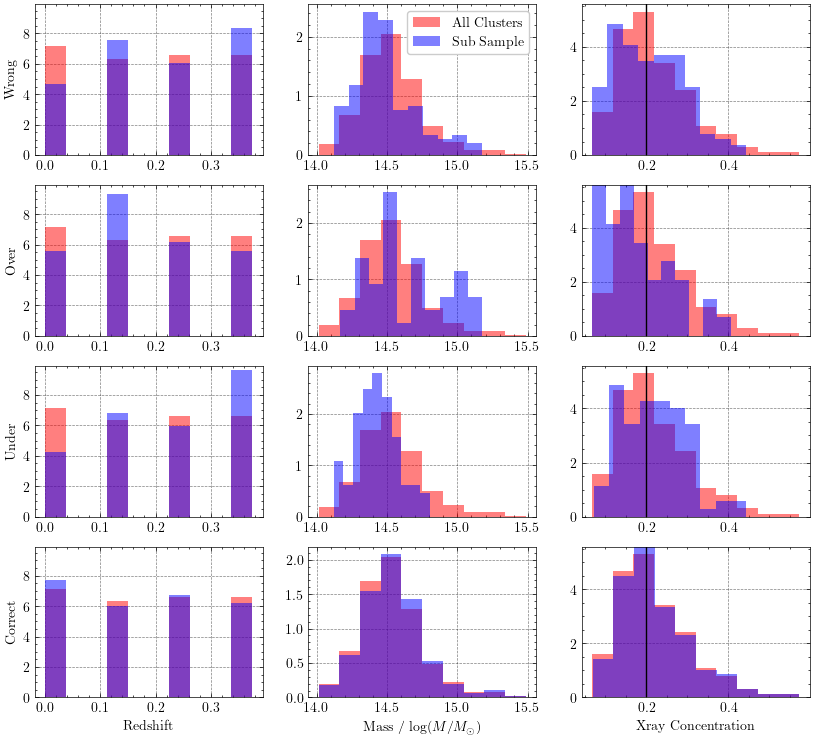

In [78]:
labels = ['redshift','mass','xrayConc']
fig, axarr = plt.subplots(4,len(labels), figsize=(10, 3*len(labels)))

for i, ilabel in enumerate(labels):
    for j in range(4):
        axarr[j,i].hist(test_params[ilabel], alpha=0.5, color='r', density=True, label="All Clusters")
        if i==0:
            axarr[j,i].set_ylim(0,9.9)
        if i == 2:
            ylim = axarr[j,i].get_ylim()
            axarr[j,i].plot( [0.2,0.2], [0,ylim[1]*1.1], 'k-')
            axarr[j,i].set_ylim(ylim)
    axarr[0,i].hist(test_params[ilabel][compare != 0], alpha=0.5, color='b', density=True, label='Sub Sample') 
    axarr[1,i].hist(test_params[ilabel][compare > 0], alpha=0.5, color='b', density=True, label='Over')
    axarr[2,i].hist(test_params[ilabel][compare < 0], alpha=0.5, color='b', density=True, label='Under')
    axarr[3,i].hist(test_params[ilabel][compare == 0], alpha=0.5, color='b', density=True, label='Right')

    
axarr[0,1].legend()

axarr[0,0].set_ylabel("Wrong")
axarr[1,0].set_ylabel("Over")
axarr[2,0].set_ylabel("Under")
axarr[3,0].set_ylabel("Correct")

axarr[-1,0].set_xlabel("Redshift")
axarr[-1,1].set_xlabel("Mass / log($M/M_\odot$)")
axarr[-1,2].set_xlabel("Xray Concentration")
fig.align_ylabels()
fig.align_xlabels()

plt.savefig("../plots/cnn_failure.pdf")

(array([1.58666193, 5.77707676, 4.75998578, 2.23760015, 1.50529465,
        0.81367278, 0.32546911, 0.12205092, 0.12205092, 0.04068364]),
 array([0.07478738, 0.13262245, 0.19045752, 0.24829259, 0.30612766,
        0.36396274, 0.42179781, 0.47963288, 0.53746795, 0.59530302,
        0.65313809]),
 <BarContainer object of 10 artists>)

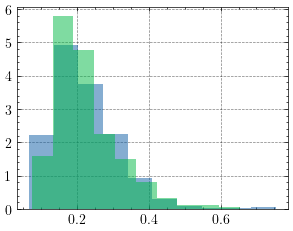

In [50]:
fig, ax = plt.subplots(1,1)
ax.hist(test_params['xrayConc'][compare != 0], density=True, alpha=0.5)
ax.hist(test_params['xrayConc'][compare == 0], density=True, alpha=0.5)

(array([0.29952575, 0.86529661, 1.71395291, 2.11332058, 1.09826109,
        0.5158499 , 0.21632415, 0.06656128, 0.16640319, 0.01664032]),
 array([14.061 , 14.2024, 14.3438, 14.4852, 14.6266, 14.768 , 14.9094,
        15.0508, 15.1922, 15.3336, 15.475 ]),
 <BarContainer object of 10 artists>)

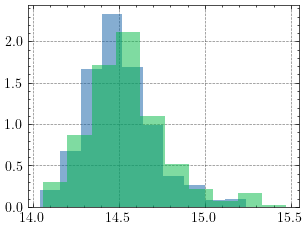

In [52]:
fig, ax = plt.subplots(1,1)
ax.hist(test_params['mass'][compare != 0], density=True, alpha=0.5)
ax.hist(test_params['mass'][compare == 0], density=True, alpha=0.5)